# BoxCox Transform of AOD and Reflectances

Using the Box Cox transform for AOD and reflectances. 

## Get the data

In [7]:
## Getting the data

from qc_c6 import QC_OCEAN, QC_LAND, QC_DEEP

aqua  = 'data/giant_C6_10km_Aqua_20151005.nc'
terra = 'data/giant_C6_10km_Terra_20150921.nc'

# Ingest Quality Controled Data
Albedo = ['CxAlbedo'] # surface characteristics
modo = QC_OCEAN(terra,Albedo=Albedo,verbose=True,
                cloud_thresh=0.80,
                glint_thresh=40.0,
                outliers=3.)

tau = modo.aTau550
ref = modo.mRef870
nref = modo.mRef870/modo.AMF
cld = modo.cloud
print(nref.max(), nref.min())


Outlier removal: -1   sig_d = 0.359961  nGood=44648 
Outlier removal: 0   sig_d = 0.294501  nGood=43515 
Outlier removal: 1   sig_d = 0.274378  nGood=42559 
Outlier removal: 2   sig_d = 0.265947  nGood=42051 
0.14515242 0.0035226466


##  AOD and Reflectance Kernel Density Estimates


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import numpy as np
import kde
from scipy import stats

bins, P = kde.calc_kde1d(tau,range=(0,1))


In [11]:

def plot_aod(tau,range=(-0.25,0.7),
             title='Aerosol Optical Depth KDE',
             xlabel=r'$\tau$',
             ylabel='Density'):
    """
    Plot KDE of log transform
    """
    x = tau

    # KDE
    bins, P = kde.calc_kde1d(x,range=range)

    # Calculate corresponding Gaussian distribution
    mu = np.mean(x)
    sig = np.std(x)
    G = 1. /(sig * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sig**2) )
    
    # Plot KDE & Gaussian
    #plt.rcParams['figure.figsize'] = (800,600)
    plt.plot(bins,P,'b',label='KDE')
    plt.plot(bins,G,'r',label='Gaussian')
    #plt.plot(bins,G*np.log(G/P),'k',label='KL Integrand')
    plt.grid()
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    # Q-Q Plot
    #plt.figure()
    #stats.probplot(P,plot=pylab)
    

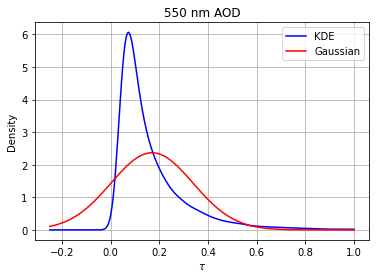

In [12]:
plot_aod(tau,range=(-0.25,1),title="550 nm AOD",xlabel=r'$\tau$')

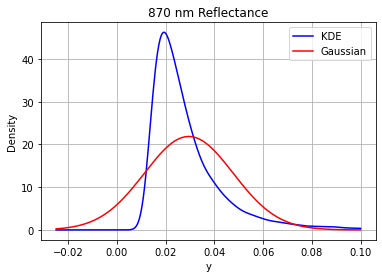

In [13]:
plot_aod(ref,range=(-0.025,0.1),title="870 nm Reflectance",xlabel='y')

## BoxCox Transform

The Box transform is defined as:
$$
 { y }_{ \lambda  }^{ ' }  =  \frac { { y }^{ \lambda  } - 1 }{ \lambda  }
$$

where $y$ must be positive. The parameter $\lambda$ is estimated by means of maximum likelihood in scipy's ``boxcox()`` function.


In [14]:
import scipy.stats   as stats
import scipy.special as special

def nBoxCox(x):
    """
    Returns normalized (z-scores) BoxCox transform.
    """
    (x_,p_)=stats.boxcox(x)
    p = (p_, x_.mean(), x_.std() )
    x_ = (x_-p[1]) / p[2]
    
    return (x_,p)
    
def inv_nBoxCox(x,p):
    """
    Inverse normalized (z-scores) BoxCox transform.
    """
    x_ = p[1] + p[2] * x 
    x_ = special.inv_boxcox(x_,p[0])
    
tau_,  pt = nBoxCox(tau)
ref_,  pr = nBoxCox(ref)
nref_, pn = nBoxCox(nref)

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


## Aerosol Optical Depth

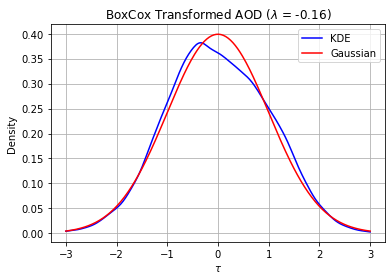

In [17]:
plot_aod(tau_,range=(-3,3),title=r'BoxCox Transformed AOD ($\lambda$ = %4.2f)'%pt[0])

In [18]:
plot_aod(ptau_,range=(-3,3),title=r'BoxCox Transformed AMF*AOD ($\lambda$ = %4.2f)'%pp[0])

NameError: name 'ptau_' is not defined

## Reflectances

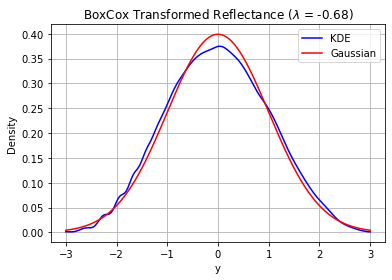

In [19]:
plot_aod(ref_,range=(-3,3),title=r'BoxCox Transformed Reflectance ($\lambda$ = %4.2f)'%pr[0],xlabel='y')

## Normalized Reflectances
Here we normalize the reflectances my the geometric airmass factor.

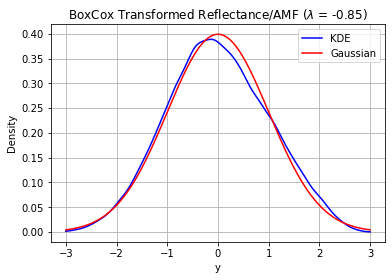

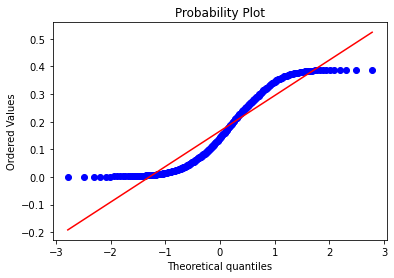

In [16]:
plot_aod(nref_,range=(-3,3),title=r'BoxCox Transformed Reflectance/AMF ($\lambda$ = %4.2f)'%pn[0],xlabel='y')